In [1]:
import re

import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt
import feather

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [ ]:
path = Path('../Data/May2015_subset.fthr')
df = feather.read_dataframe(path)

In [16]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']

In [17]:
df = df[df.subreddit.isin(subreddit_list)]

In [18]:
df.reset_index(inplace=True, drop=True)

In [19]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')

In [20]:
df['is_flair'] = ~df.author_flair_text.apply(lambda x: x is None)
df['is_flair_css'] = ~df.author_flair_css_class.apply(lambda x: x is None)

Columns with no extra information

In [21]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col)

score_hidden
removal_reason
downs
archived


In [22]:
df.drop(['archived', 'id', 'removal_reason',
         'score_hidden', 'downs', 'subreddit_id',
         'author_flair_css_class', 'author_flair_text',
         'author'], axis=1, inplace=True)

In [23]:
import gc
gc.collect()

49

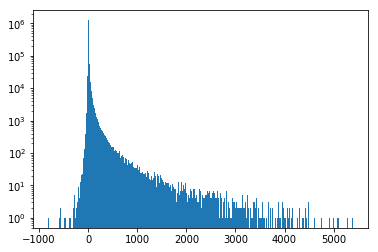

In [24]:
plt.hist(df.score, log=True, bins=300);

In [25]:
df.subreddit.value_counts()

worldnews    490354
movies       376601
gaming       361265
science       89413
food          55231
Name: subreddit, dtype: int64

In [26]:
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [27]:
df.drop(['created_utc'], axis=1, inplace=True)

In [28]:
df.tail().T

,1372859,1372860,1372861,1372862,1372863
ups,1,1,170,9,37
link_id,t3_37z0mw,t3_37z0mw,t3_37zl5z,t3_380j06,t3_37z0mw
name,t1_crrbebf,t1_crrbecs,t1_crrbedn,t1_crrbefm,t1_crrbeft
subreddit,worldnews,worldnews,worldnews,worldnews,worldnews
gilded,0,0,0,0,0
score,1,1,170,9,37
retrieved_on,1433505915,1433505915,1433505916,1433505916,1433505916
body,"The key there is ""unless they're sociopaths"". ...",Pretty sure they don't just behead people outr...,Because it's not typically done to babies. It'...,&gt; Nothing they are doing is illegal under i...,Apart from the risk of inhalation pneumonia.
distinguished,NaN,NaN,NaN,NaN,NaN
edited,0,0,0,0,0


In [29]:
dfl = pd.read_pickle('Data/scrape/df_final.pkl')

In [30]:
dfl.shape

(45400, 18)

Over lapping columns

In [31]:
[c for c in df.columns if c in dfl.columns]

['ups', 'score', 'distinguished', 'edited']

In [32]:
for col in dfl.columns:
    if len(dfl[col].unique()) == 1:
        print(col)

locked
downs
is_original_content
view_count


This will save some precious RAM when joining the data frame!!

In [33]:
dfl['url'] = dfl.url.astype('category')
dfl['selftext'] = dfl.selftext.astype('category')
dfl['title'] = dfl.title.astype('category')

In [34]:
dfl['link_created_time'] = pd.to_datetime(dfl.created_utc, unit='s')

In [35]:
dfl.drop(['locked', 'downs', 'is_original_content',
          'view_count', 'distinguished', 'edited',
          'num_crossposts', 'spoiler', 'created_utc'], axis=1, inplace=True)

In [36]:
dfl.rename(columns={'sub_id':'link_id', 
                    'ups': 'link_ups',
                    'score': 'link_score'}, inplace=True)

In [37]:
dfl.tail().T

,45395,45396,45397,45398,45399
link_id,t3_380j06,t3_380k50,t3_380ld3,t3_380lty,t3_380msc
url,https://www.yahoo.com/news/us-demands-immediat...,http://www.irishtimes.com/news/world/middle-ea...,http://www.timesofisrael.com/israels-army-skir...,http://time.com/3902702/us-college-student-isi...,http://www.healthy4u.net/2015/05/30/easy-diet-...
num_comments,10,1,6,5,1
over_18,False,False,False,False,False
link_score,9,9,0,8,1
selftext,,,,,
title,"US hits out at China over sea reclamation, vow...",Israel moves to toughen sentences for stone-th...,Israel's Army operating program to convert Jew...,Hero Student Tries to Stop ISIS Attack in Saud...,easy diet
upvote_ratio,0.62,0.84,0.38,0.68,1
link_ups,9,9,0,8,1
link_created_time,2015-05-31 23:19:50,2015-05-31 23:29:11,2015-05-31 23:38:41,2015-05-31 23:42:18,2015-05-31 23:50:20


In [38]:
df = df.merge(dfl, on='link_id', how='left')
# for some reason the join doesn't work
# df = df.join(other=dfl, on='link_id', how='outer')

In [39]:
df.shape

(1372864, 24)

In [40]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.9037070584606572 GB'

In [41]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

In [42]:
df['time_since_link'] = df.time - df.link_created_time

In [43]:
df.time_since_link = df.time_since_link.apply(lambda x: x.total_seconds())

In [44]:
comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return np.nan
        counter += 1
        
df['depth'] = df['name'].apply(get_depth)

Just keeping the domain

In [45]:
df['url'] = df.url.astype('str').apply(lambda x: urlparse(x)[1])
dfl['url'] = dfl.url.astype('category')

In [46]:
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [47]:
regex = re.compile('[^a-zA-Z]')

In [48]:
df['linked_sr'] = df.linked_sr.apply(lambda x: [regex.sub('', i).lower() for i in x])

In [49]:
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def get_domains(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url)[1] for url in urls]
    except:
        return []
    return domain_names

def remove_urls(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)


df['linked_urls'] = df.body.apply(lambda x: get_domains(x))
df['body'] = df.body.apply(lambda x: remove_urls(x))

In [50]:
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [51]:
top_url_links = []

for sub in df.subreddit.unique():
    all_linked_urls = []
    for l in df[df.subreddit == sub].linked_urls.values:
        all_linked_urls += l

    top_url_links += Counter(all_linked_urls).most_common(5)

allowed_urls = list(set([i[0] for i in top_url_links]))

In [52]:
top_sr_links = []

for sub in df.subreddit.unique():
    all_linked_sr = []
    for l in df[df.subreddit == sub].linked_sr.values:
        all_linked_sr += l

    top_sr_links += Counter(all_linked_sr).most_common(5)

allowed_sr = list(set([i[0] for i in top_sr_links]))

In [53]:
def remove_sr(x):
    y = []
    for i in x:
        if i in allowed_sr:
            y += [i]
    return y

def remove_urls(x):
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

df['a_linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))
df['a_linked_sr'] = df['linked_sr'].apply(lambda x: remove_sr(x))

In [54]:
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

def get_score(x):
    try:
        return comment_to_score[x]
    except:
        return np.nan

df['parent_score'] = df.parent_id.apply(lambda x: get_score(x))
imp_val = df.parent_score.median()
df.parent_score.fillna(imp_val, inplace=True)

In [55]:
def get_comment_tree_root(x):
    if comment_to_parent_dict[x][:3] == 't3_':
        return x
    try:
        return get_comment_tree_root(comment_to_parent_dict[x])
    except KeyError:
        return np.nan

In [56]:
df['comment_tree_root_id'] = df.name.apply(get_comment_tree_root)

In [57]:
df['comment_tree_root_score'] = df.comment_tree_root_id.apply(lambda x: get_score(x))

In [58]:
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time(x):
    try:
        return comment_to_time[x]
    except:
        return np.nan

In [59]:
df['time_since_comment_tree_root'] = df.time - df.comment_tree_root_id.apply(get_time)

In [60]:
df.time_since_comment_tree_root = df.time_since_comment_tree_root.apply(lambda x: x.total_seconds())

In [61]:
df['subjectivity'] = df['body'].str.count('I ')

In [62]:
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [63]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [64]:
def get_sentiment(x):
    return analyser.polarity_scores(x)

In [65]:
from multiprocessing import Pool

num_partitions = 100
num_cores = 6

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [66]:
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)

df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])

del sentiment

Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-66-0e174f501523>", line 2, in wrapper_get_sentiment
    df['sentiment'] = df['body'].apply(get_sentiment)
  File "/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/series.py", line 3194, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas/_libs/src/inference.pyx", line 1472, in pandas._libs.lib.map_infer
  File 

KeyboardInterrupt: 

  File "<ipython-input-64-f13186852d2e>", line 2, in get_sentiment
    return analyser.polarity_scores(x)
  File "/Applications/anaconda3/lib/python3.6/site-packages/vaderSentiment/vaderSentiment.py", line 275, in polarity_scores
    sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)
  File "/Applications/anaconda3/lib/python3.6/site-packages/vaderSentiment/vaderSentiment.py", line 302, in sentiment_valence
    s = scalar_inc_dec(words_and_emoticons[i - (start_i + 1)], valence, is_cap_diff)
KeyboardInterrupt
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "pandas/_libs/src/inference.pyx", line 1472, in pandas._libs.lib.map_infer
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(

In [ ]:
gc.collect()

In [ ]:
df['is_quoted'] = df.body.str.contains('&gt;')
df['no_quoted'] = df.body.str.count('&gt;')
df['time_since_parent'] = df.parent_id.apply(get_time)
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time
df.time_since_parent = df.time - df.time_since_parent
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [ ]:
df['is_root'] = df.parent_id.str.startswith('t3_')

In [ ]:
df['is_selftext'] = df.selftext.str.len() > 1

In [60]:
df.shape

(1372864, 47)

In [61]:
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count

del word_counts

In [62]:
df['epoch_time'] = df.time.astype(np.int64) // 10**9

In [63]:
import gc
gc.collect()

21

In [7]:
# df.to_pickle('Temp1.pkl')
df = pd.read_pickle('Temp1.pkl')

In [117]:
def get_past_stats_dict(lid):
    dfs = df[df.link_id == lid][['time', 'score', 'name']]
    dfs = dfs.sort_values(by='time', ascending=True).reset_index(drop=True)
    dfs.reset_index(inplace=True)
    t_dict = pd.DataFrame(data=dfs[['index', 'score']].values,
                        index=dfs['name'].values,
                        columns=['no_of_comments', 'score']).to_dict('index')
    return t_dict

In [43]:
pool = Pool(num_cores)
list_dicts = pool.map(get_past_stats_dict, df.link_id.unique())

In [24]:
len(list_dicts)

46546

In [25]:
df.link_id.unique().shape

(46546,)

In [33]:
from collections import ChainMap
# y = dict(ChainMap(*list_dicts))

In [40]:
y = pd.concat([pd.DataFrame.from_dict(d, orient='index') for d in list_dicts])

In [41]:
y.shape

(1372864, 2)

In [45]:
y = y.to_dict('index')

In [46]:
y['t1_cr0uefd']['no_of_comments']

5

In [47]:
df['no_of_past_comments'] = df.name.apply(lambda x: y[x]['no_of_comments'])

In [48]:
df['score_till_now'] = df.name.apply(lambda x: y[x]['score'])

Using Pandas `.query` method for high performance subsetting.
check [this out](https://jakevdp.github.io/PythonDataScienceHandbook/03.12-performance-eval-and-query.html)

In [49]:
# dfc = df[['link_id', 'time']].copy(deep=True)

In [50]:
# dfc.set_index(['link_id', 'time'], inplace=True)

In [51]:
# def get_past_stats(x):
#     lid, t = x.split('|')
#     # return dfc.query(f"link_id == '{lid}' and time < '{t}'").shape[0]
#     no_of_cmnts = temp.shape[0]
#     score = temp['score'].sum()
#     p = temp.query('score >= 0')['score'].sum()
#     n = abs(temp.query('score < 0')['score'].sum())
#     if not (p == 0 and n == 0):
#         up_ratio = p / (p + n)
#     else:
#         up_ratio = 1
#     return no_of_cmnts, score, up_ratio

In [52]:
#dft = pd.DataFrame(df.link_id + '|' + df.time.map(str), columns=['temp_id'])

In [53]:
# def wrapper_past_stats(df):
#     df['pat_stats'] = df['temp_id'].apply(get_past_stats)
#     return df

In [54]:
# parallelize_dataframe(dft, wrapper_past_stats)

In [55]:
gc.collect()

75

In [27]:
# df.to_pickle('Data/Temp4.pkl')
df = pd.read_pickle('Data/Temp4.pkl')

In [28]:
df.tail().T

,1372859,1372860,1372861,1372862,1372863
ups,1,1,170,9,37
link_id,t3_37z0mw,t3_37z0mw,t3_37zl5z,t3_380j06,t3_37z0mw
name,t1_crrbebf,t1_crrbecs,t1_crrbedn,t1_crrbefm,t1_crrbeft
subreddit,worldnews,worldnews,worldnews,worldnews,worldnews
gilded,0,0,0,0,0
score,1,1,170,9,37
retrieved_on,1433505915,1433505915,1433505916,1433505916,1433505916
body,"The key there is ""unless they're sociopaths"". ...",Pretty sure they don't just behead people outr...,Because it's not typically done to babies. It'...,&gt; Nothing they are doing is illegal under i...,Apart from the risk of inhalation pneumonia.
distinguished,NaN,NaN,NaN,NaN,NaN
edited,0,0,0,0,0


In [29]:
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [30]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector

    return glove

def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]

    return terms

def get_doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)

    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

gloves = load_glove('Data/glove.twitter.27B.200d.txt')

In [31]:
from scipy.spatial.distance import cosine, euclidean

In [32]:
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')

def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return None
    child = get_doc2vec(child, gloves)
    parent = get_doc2vec(parent, gloves)
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent), euclidean(child, parent)

def wrapper_get_cosine(df):
    df['cosine_euc'] = df['name'].apply(get_cosine_angle)
    return df

cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)

df['cosine_euc'] = cosine_angle.cosine_euc

del cosine_angle

In [33]:
df['parent_cosine'] = df.cosine_euc.apply(lambda x: x[0] if x is not None else None)
df['parent_euc'] = df.cosine_euc.apply(lambda x: x[1] if x is not None else None)

In [34]:
df.drop(['cosine_euc'], inplace=True, axis=1)

In [35]:
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_title = pd_to_dict(df[['name', 'title']],
                                index='name', column='title')

In [36]:
def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_title[cmnt_id]
        child = get_doc2vec(child, gloves)
        parent = get_doc2vec(parent, gloves)
    except:
        return None
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent), euclidean(child, parent)

def wrapper_get_cosine(df):
    df['cosine_euc'] = df['name'].apply(get_cosine_angle)
    return df

In [37]:
cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)
df['cosine_euc'] = cosine_angle.cosine_euc
del cosine_angle

In [38]:
df['title_cosine'] = df.cosine_euc.apply(lambda x: x[0] if x is not None else None)
df['title_euc'] = df.cosine_euc.apply(lambda x: x[1] if x is not None else None)

In [39]:
# del comment_to_body
# del comment_to_parent
# del comment_to_score
# del comment_to_time
# del comment_to_title
# del glovesd

In [44]:
df.shape

(1372864, 56)

In [41]:
df.to_pickle('Data/new_data.pkl')
# df = pd.read_pickle('Data/new_data.pkl')

Cleaning

In [42]:
df.columns

Index(['ups', 'link_id', 'name', 'subreddit', 'gilded', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id', 'is_flair', 'is_flair_css', 'time', 'url', 'num_comments',
       'over_18', 'link_score', 'selftext', 'title', 'upvote_ratio',
       'link_ups', 'link_created_time', 'time_since_link', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'a_linked_sr', 'parent_score', 'comment_tree_root_id',
       'comment_tree_root_score', 'time_since_comment_tree_root',
       'subjectivity', 'is_edited', 'senti_neg', 'senti_neu', 'senti_pos',
       'senti_comp', 'is_quoted', 'no_quoted', 'time_since_parent', 'is_root',
       'is_selftext', 'word_counts', 'epoch_time', 'no_of_past_comments',
       'score_till_now', 'parent_cosine', 'parent_euc', 'cosine_euc',
       'title_cosine', 'title_euc'],
      dtype='object')

In [43]:
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)
df['distinguished'] = df.distinguished.astype('category')

In [68]:
df['no_of_quoted_users'] = df.body.str.count('/u/')

In [78]:
df['hour_of_comment'] = df.time.apply(lambda x: x.hour)

In [81]:
df['weekday'] = df.time.dt.weekday

In [83]:
top_turls_links = []

for sub in df.subreddit.unique():
    top_turls_links += Counter(df[df.subreddit == sub].url.values).most_common(15)

allowed_turls = list(set([i[0] for i in top_turls_links]))

In [84]:
allowed_turls

['www.pcgamer.com',
 'www.kickstarter.com',
 'www.veggiesdontbite.com',
 'www.sciencealert.com',
 'www.the-aps.org',
 'en.abna24.com',
 'www.youtube.com',
 'gtaforums.com',
 'www.nature.com',
 'www.theatlantic.com',
 'www.independent.co.uk',
 'www.uq.edu.au',
 'www.theguardian.com',
 'www.bbc.com',
 'www.realclearscience.com',
 'www.ynetnews.com',
 'www.imgur.com',
 'www.telesurtv.net',
 'comicbook.com',
 'www.bbc.co.uk',
 'www.npr.org',
 'www.washingtonpost.com',
 'arstechnica.com',
 'www.hollywoodreporter.com',
 'i.imgur.com',
 'www.ibtimes.co.uk',
 'www.nytimes.com',
 'variety.com',
 'cdn.shopify.com',
 'phys.org',
 'www.flickr.com',
 'www.cnn.com',
 'youtu.be',
 'en.wikipedia.org',
 'res.cloudinary.com',
 'geektyrant.com',
 'www.yahoo.com',
 'i1.wp.com',
 'gfycat.com',
 'techti.me',
 'www.sciencedaily.com',
 'marvel.com',
 'www.cbc.ca',
 'www.ncbi.nlm.nih.gov',
 'www.warcraftmovies.com',
 'www.huffingtonpost.com',
 'www.businessinsider.com',
 'news.yahoo.com',
 'm.imgur.com',
 'img

In [86]:
df['title_url_in_top'] = df.url.apply(lambda x: x in allowed_turls)

In [45]:
df = df[~df.depth.isna()]

In [61]:
df.loc[df.is_root, 'parent_cosine'] = 1

In [48]:
df.parent_euc.fillna(df.parent_euc.mean(), inplace=True)

In [49]:
df.word_counts.quantile(0.995)

285.0

In [50]:
df = df[df['word_counts'] < 280]

In [51]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']

In [52]:
df.reset_index(inplace=True, drop=True)

In [53]:
df = df[~df.title_cosine.isna()]
df = df[~df.title_euc.isna()]

In [63]:
df = df[~df.parent_cosine.isna()]

In [54]:
df.shape

(1187058, 57)

### Max start here

In [216]:
# Max read data from local source (TODO -- delete later)
df = pd.read_pickle('/Users/maxalfaro/Desktop/Finale.pkl')

# Remove root comments 
df = df.loc[df.is_root == False]

**Explore the features**

In [4]:
df.columns

Index(['ups', 'link_id', 'name', 'subreddit', 'gilded', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id', 'is_flair', 'is_flair_css', 'time', 'url', 'num_comments',
       'over_18', 'link_score', 'selftext', 'title', 'upvote_ratio',
       'link_ups', 'link_created_time', 'time_since_link', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'a_linked_sr', 'parent_score', 'comment_tree_root_id',
       'comment_tree_root_score', 'time_since_comment_tree_root',
       'subjectivity', 'is_edited', 'senti_neg', 'senti_neu', 'senti_pos',
       'senti_comp', 'is_quoted', 'no_quoted', 'time_since_parent', 'is_root',
       'is_selftext', 'word_counts', 'epoch_time', 'no_of_past_comments',
       'score_till_now', 'parent_cosine', 'parent_euc', 'cosine_euc',
       'title_cosine', 'title_euc', 'no_of_quoted_users', 'hour_of_comment',
       'weekday', 'title_url_in_top'],
      d

We want to split these into three broad categories, and thus treat them accordingly:

* **Categorical Variables** - `subreddit`, `distinguished`

* **Boolean Variables** - `over_18`, `is_edited`, `is_quoted`, `is_root`, `is_selftext`, `is_flair`, `is_flair_css`  

* **Numeric Variables** - `gilded`, `controversiality`, `num_comments`, `link_score`, `upvote_ratio`, `link_ups`, `time_since_link`, `depth`, `no_of_linked_sr`, `no_of_linked_urls`, `parent_score`, `comment_tree_root_score`, `time_since_comment_tree_root`, `subjectivity`, `senti_neg`, `senti_pos`, `senti_neu`, `senti_comp`, `no_quoted`, `time_since_parent`, `word_counts`, `title_cos_angle`, `parent_cos_angle`

In [5]:
cat_cols = ['subreddit', 'distinguished', 'is_flair', 'is_flair_css']

bool_cols = ['over_18', 'is_edited', 'is_quoted', 'is_root', 'is_selftext',
             'title_url_in_top']

numeric_cols = ['gilded', 'controversiality', 'upvote_ratio','time_since_link',
                'depth', 'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'no_of_past_comments', 'parent_cosine',
                'parent_euc', 'title_cosine', 'title_euc', 'no_of_quoted_users',
                'hour_of_comment', 'weekday']

features = numeric_cols + bool_cols + cat_cols

Using feature importance metrics from the random forest model

In [4]:
top_five_features = ['parent_score', 'time_since_parent', 'no_of_past_comments', 'time_since_comment_tree_root', 'gilded']
top_five_features

['parent_score',
 'time_since_parent',
 'no_of_past_comments',
 'time_since_comment_tree_root',
 'gilded']

In [44]:
# Actually don't do this. 
# med = np.median(df.comment_tree_root_score)
# df['comment_tree_root_score'] = df[['is_root', 'comment_tree_root_score']].apply(lambda line : line[1] if not line[0] else med, axis = 1)

### Plotting

In [5]:
import seaborn as sns
import calendar

Let's explore how some features that we think would be the most important are related to score. We believe that some of the best features would be

**Comments by day of the week**

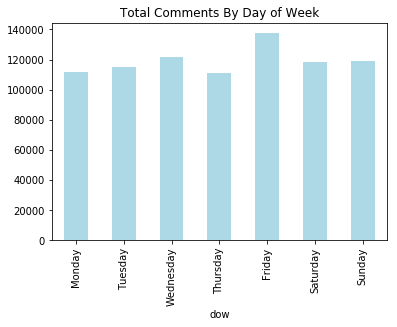

In [80]:
d = dict(enumerate(calendar.day_name))
weekday = pd.DataFrame({'dow' : list(d.values()), 'valueCount' : list(weekday_counts)})

weekday.plot(x = 'dow', y = 'valueCount', kind = 'bar', color = 'lightblue', 
             title = 'Total Comments By Day of Week', legend = False)

In [84]:
df.columns

Index(['ups', 'link_id', 'name', 'subreddit', 'gilded', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id', 'is_flair', 'is_flair_css', 'time', 'url', 'num_comments',
       'over_18', 'link_score', 'selftext', 'title', 'upvote_ratio',
       'link_ups', 'link_created_time', 'time_since_link', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'a_linked_sr', 'parent_score', 'comment_tree_root_id',
       'comment_tree_root_score', 'time_since_comment_tree_root',
       'subjectivity', 'is_edited', 'senti_neg', 'senti_neu', 'senti_pos',
       'senti_comp', 'is_quoted', 'no_quoted', 'time_since_parent', 'is_root',
       'is_selftext', 'word_counts', 'epoch_time', 'no_of_past_comments',
       'score_till_now', 'parent_cosine', 'parent_euc', 'cosine_euc',
       'title_cosine', 'title_euc', 'no_of_quoted_users', 'hour_of_comment',
       'weekday', 'title_url_in_top'],
      d

In [182]:
t = df.groupby(["weekday", "subreddit"]).size()

weekdays = ['M']*5 + ['Tu']*5 + ['W']*5 + ['Th']*5 + ['F']*5 + ['Sa']*5 + ['Su']*5
subreddits = list(t.index.levels[1]) * 7
num_comments = list(t)

dow_df = pd.DataFrame({'Weekday':weekdays, 'Subreddit':subreddits, 'Num_Comments':num_comments})

In [180]:
dow_df

,Weekday,subreddits,numcomments
0,M,food,2923
1,M,gaming,27135
2,M,movies,33459
3,M,science,5462
4,M,worldnews,42760
5,Tu,food,2922
6,Tu,gaming,26784
7,Tu,movies,33249
8,Tu,science,5869
9,Tu,worldnews,46296


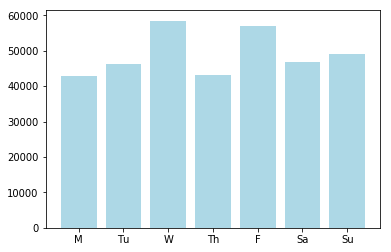

In [197]:
fig, ax = plt.subplots()

colors = {'food':'orange', 'gaming':'red', 'movies':'brown', 'science':'lightgreen', 'worldnews':'lightblue'}

ax.bar(x=dow_df['Weekday'], height=dow_df['Num_Comments'], color=dow_df['Subreddit'].apply(lambda x: colors[x]))

plt.show()

**How does `gilded` affect `score`? 

Text(0,0.5,'Median Score')

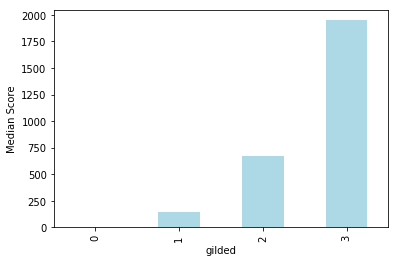

In [177]:
ax = df.groupby(['gilded'])['score'].median().plot(kind='bar', color = 'lightblue', legend=False)

ax.set_ylabel("Median Score")

**Important features by score**

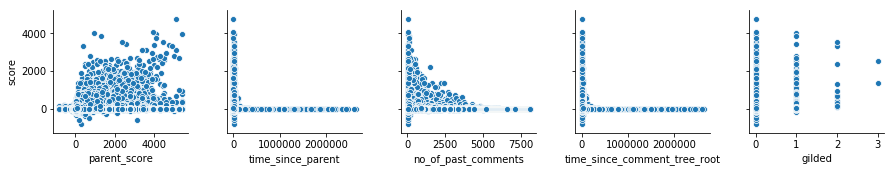

In [155]:
sns.pairplot(data=df,
                  y_vars=['score'],
                  x_vars=top_five_features)

In [ ]:
df

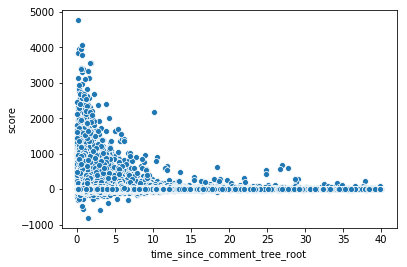

In [217]:
t = df 
t['time_since_comment_tree_root'] = t.time_since_comment_tree_root / 60 / 60 
t = t[t.time_since_comment_tree_root < 40]
sns.scatterplot(x = t.time_since_comment_tree_root, y = t.score)

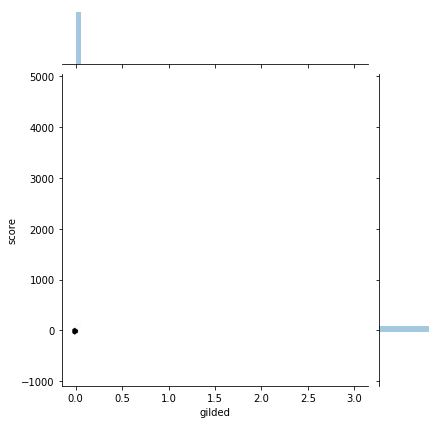

In [166]:
sns.jointplot(x=df.gilded, y=df.score, kind='hex')

**Number of missing data**

In [78]:
df.isna().sum().sum() # Notice there are no NAs in any column

0

### Max stop here

In [135]:
cat_cols = ['subreddit', 'distinguished', 'is_flair', 'is_flair_css']
bool_cols = ['over_18', 'is_edited', 'is_quoted', 'is_root', 'is_selftext',
             'title_url_in_top']

# multi_label = a_linked_sr, a_linked_urls
# 'num_comments', 'link_score',  'link_ups', 

numeric_cols = ['gilded', 'controversiality', 'upvote_ratio','time_since_link',
                'depth', 'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'no_of_past_comments', 'parent_cosine',
                'parent_euc', 'title_cosine', 'title_euc', 'no_of_quoted_users',
                'hour_of_comment', 'weekday']

features = numeric_cols + bool_cols + cat_cols

In [114]:
df = pd.read_pickle('Data/Finale.pkl')
# df.to_pickle('Data/Finale.pkl')

In [91]:
del gloves

In [108]:
from scipy.sparse import hstack

In [109]:
lb = LabelBinarizer()

In [110]:
cat = [lb.fit_transform(df[col]) for col in cat_cols]
bol = [df[col].astype('int') for col in bool_cols]
t = df.loc[:, numeric_cols].values
final = [t] + bol + cat

In [111]:
y = df.score.values
x = np.column_stack(tuple(final))

In [112]:
df.shape

(1176815, 60)

In [113]:
x.shape

(1176815, 42)

In [114]:
gc.collect()

1257

In [115]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

In [116]:
del x, y

In [117]:
from sklearn.ensemble import RandomForestRegressor

In [118]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=10)
m.fit(X_train, y_train)

KeyboardInterrupt: 

In [144]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.7619
RMSE: 35.57700592639819


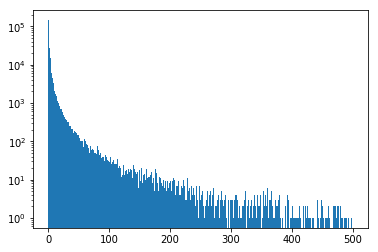

In [145]:
plt.hist(abs(y_test - y_predicted), bins=400, range=[0, 500], log=True);

In [146]:
# feature importance
[(x,_) for _,x in sorted(zip(m.feature_importances_, features), reverse=True)]

[('comment_tree_root_score', 0.5737095567480381),
 ('time_since_comment_tree_root', 0.09953385611428422),
 ('depth', 0.05836990576537382),
 ('parent_score', 0.052781666368458637),
 ('time_since_parent', 0.050227349946586966),
 ('gilded', 0.0411655859333329),
 ('no_of_past_comments', 0.03032235213054648),
 ('is_root', 0.019519065240750956),
 ('time_since_link', 0.00909532849305108),
 ('title_euc', 0.00666592002516817),
 ('controversiality', 0.006169863268698647),
 ('parent_cosine', 0.005873779669444114),
 ('parent_euc', 0.005653879765141191),
 ('word_counts', 0.005428720442875631),
 ('title_cosine', 0.005350348416618924),
 ('hour_of_comment', 0.004920413818315175),
 ('senti_neu', 0.00429614331207919),
 ('senti_comp', 0.004198729967855686),
 ('upvote_ratio', 0.003514887323901297),
 ('senti_pos', 0.0030441919801276218),
 ('senti_neg', 0.0029492414915632766),
 ('weekday', 0.0023102390267444187),
 ('distinguished', 0.0009329030911415486),
 ('is_selftext', 0.0008928627411682657),
 ('is_flair

----------------------------

In [147]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
m = GradientBoostingRegressor(n_estimators=60, max_depth=15)
m.fit(X_train, y_train)

In [ ]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

In [ ]:
plt.hist(abs(y_test - y_predicted), bins=400, range=[0, 500], log=True);

---------------

In [153]:
import xgboost

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=80, max_depth=15)

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
y_predicted = xgb.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")